# NOAA Weather Data EDA

## 1. Load and Import Packages 

In [8]:
import pandas as pd 
import numpy as np
import re
import os
import math
import datetime
from datetime import datetime
import time

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import pickle

import seaborn as sns
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)

## 2. Set up File Paths

In [71]:
import_bucket = "C:/Users/Christian Conroy/Documents/2021_2022/Job Search/Applications/ATT/NOAA_Weather_Analysis/data/isd-lite/"

output_bucket = "C:/Users/Christian Conroy/Documents/2021_2022/Job Search/Applications/ATT/NOAA_Weather_Analysis/outputs/"

## 3. Import Data 

"ISH" (Integrated Surface Hourly) was renamed around 2004 with "ISD" (Integrated Surface Data) when daily and monthly summary observations where added to the dataset.

In [72]:
isd_history = pd.read_csv('ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.csv')
isd_history.head(10)

USAF   WBAN STATION NAME CTRY STATE ICAO    LAT     LON  ELEV(M)  \
0  007018  99999   WXPOD 7018  NaN   NaN  NaN   0.00   0.000   7018.0   
1  007026  99999   WXPOD 7026   AF   NaN  NaN   0.00   0.000   7026.0   
2  007070  99999   WXPOD 7070   AF   NaN  NaN   0.00   0.000   7070.0   
3  008260  99999    WXPOD8270  NaN   NaN  NaN   0.00   0.000      0.0   
4  008268  99999    WXPOD8278   AF   NaN  NaN  32.95  65.567   1156.7   
5  008307  99999   WXPOD 8318   AF   NaN  NaN   0.00   0.000   8318.0   
6  008411  99999         XM20  NaN   NaN  NaN    NaN     NaN      NaN   
7  008414  99999         XM18  NaN   NaN  NaN    NaN     NaN      NaN   
8  008415  99999         XM21  NaN   NaN  NaN    NaN     NaN      NaN   
9  008418  99999         XM24  NaN   NaN  NaN    NaN     NaN      NaN   

      BEGIN       END  
0  20110309  20130730  
1  20120713  20170822  
2  20140923  20150926  
3  20050101  20120731  
4  20100519  20120323  
5  20100421  20100421  
6  20160217  20160217  
7  20160216  20160217  
8  20160217  20200314  
9  20160217  20160217

In [73]:
isd_history['station_id'] = isd_history.apply(lambda x: str(x['USAF']) + "-" + str(x['WBAN']), axis=1)

Subset isd to stations with isd history data 

In [74]:
import ftplib

ftp = ftplib.FTP("ftp.ncdc.noaa.gov")

ftp.login()

'230-****** WARNING ** WARNING ** WARNING ** WARNING ** WARNING ** ** WARNING ** WARNING ** WARNING ******\n ** You are accessing a U.S. Government information system, which includes:                         **\n ** 1) This computer, 2)This computer network, 3) All computers connected to this network, and      **\n ** 4) All devices and storage media attached to this network or to a computer on this network.     **\n ** You understand and consent to the following:                                                    **\n ** you may access this information system for authorized use only; you have no reasonable          **\n ** expectation of privacy regarding any communication of data transiting or stored on this         **\n ** information system; at any time and for any lawful Government purpose, the Government may       **\n ** monitor, intercept, and search and seize any communication or data transiting or stored on      **\n ** this information system; and any communications or data 

In [75]:
year_range = range(2017, 2021)
full_ftp = []
for i in year_range:
    ftp_l = ftp.nlst("/pub/data/noaa/isd-lite/" + str(i))
    full_ftp = full_ftp + ftp_l

In [76]:
ftp.close()

In [77]:
year_f = pd.DataFrame(year_range)
year_f['for_merge'] = 1
year_f = year_f.rename(columns={0: "years"})
year_f

years  for_merge
0   2017          1
1   2018          1
2   2019          1
3   2020          1

In [78]:
isd_history['for_merge'] = 1 

In [79]:
isd_history_sub = pd.merge(isd_history, year_f, how = "left", on = "for_merge")
isd_history_sub.head()

USAF   WBAN STATION NAME CTRY STATE ICAO  LAT  LON  ELEV(M)     BEGIN  \
0  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
1  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
2  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
3  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
4  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   

        END    station_id  for_merge  years  
0  20130730  007018-99999          1   2017  
1  20130730  007018-99999          1   2018  
2  20130730  007018-99999          1   2019  
3  20130730  007018-99999          1   2020  
4  20170822  007026-99999          1   2017

In [80]:
isd_history_sub['filename'] = isd_history_sub['station_id'] + "-" + isd_history_sub['years'].astype('str')
isd_history_sub.head(10)

USAF   WBAN STATION NAME CTRY STATE ICAO  LAT  LON  ELEV(M)     BEGIN  \
0  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
1  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
2  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
3  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
4  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   
5  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   
6  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   
7  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   
8  007070  99999   WXPOD 7070   AF   NaN  NaN  0.0  0.0   7070.0  20140923   
9  007070  99999   WXPOD 7070   AF   NaN  NaN  0.0  0.0   7070.0  20140923   

        END    station_id  for_merge  years           filename  
0  20130730  007018-99999          1   2017  007018-99999-2017  
1  20130730  007018-99999          1   2018  007018-99999-2018  
2  20130730  007018-99999          1   2019  007018-99999-2019  
3  20130730  007018-99999          1   2020  007018-99999-2020  
4  20170822  007026-99999          1   2017  007026-99999-2017  
5  20170822  007026-99999          1   2018  007026-99999-2018  
6  20170822  007026-99999          1   2019  007026-99999-2019  
7  20170822  007026-99999          1   2020  007026-99999-2020  
8  20150926  007070-99999          1   2017  007070-99999-2017  
9  20150926  007070-99999          1   2018  007070-99999-2018

In [81]:
isd_history_sub = isd_history_sub[isd_history_sub['filename'].isin([i.rsplit('/', 1)[1].rsplit(".",1)[0] for i in full_ftp])]
isd_history_sub.head()

USAF   WBAN         STATION NAME CTRY STATE  ICAO     LAT    LON  \
44  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   
45  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   
46  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   
47  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   
52  010014  99999           SORSTOKKEN   NO   NaN  ENSO  59.792  5.341   

    ELEV(M)     BEGIN       END    station_id  for_merge  years  \
44      9.0  19310101  20220330  010010-99999          1   2017   
45      9.0  19310101  20220330  010010-99999          1   2018   
46      9.0  19310101  20220330  010010-99999          1   2019   
47      9.0  19310101  20220330  010010-99999          1   2020   
52     48.8  19861120  20220330  010014-99999          1   2017   

             filename  
44  010010-99999-2017  
45  010010-99999-2018  
46  010010-99999-2019  
47  010010-99999-2020  
52  010014-99999-2017

### Bring in GA Data over past 4 years

In [82]:
# Column Names were determined from ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.pdf.
isd_fwf_cols = ['year', 'month', 'day', 'hour', 'air_temp_c', 'dew_pt_temp_c',
                 'sea_lvl_press_hectoPa', 'wnd_dir_360', 'wnd_spd_mtrpersec',
                 'sky_condition', 'precip_hrly', 'precip_6hr_accum']

In [83]:
# Restrict Locations to GA State
US_search = isd_history_sub.loc[(isd_history_sub['STATION NAME'].isna() == False) 
                                   & (isd_history_sub['CTRY'].str.contains('US'))]

GA_search = US_search.loc[(US_search['STATION NAME'].isna() == False) 
                                   & (US_search['STATE'].str.contains('GA'))]

In [84]:
station_id_list = GA_search['station_id'].unique().tolist()

In [85]:
len(station_id_list)

46

In [86]:
len(station_id_list) * len(year_range)
# 490 files for GA over ten years

184

In [87]:
len(station_id_list) * len(year_range)*365

67160

In [88]:
len(station_id_list) * len(year_range)*365*24
#204,768 for 4 years for all US
# 4,416 for 4 years for GA (11,760 for 10)

1611840

Test Import

In [89]:
# Function to loop through a given station ID for a given range of years.
def download_isd_lite(station_id, year_range):
    isd_df = pd.DataFrame()
    for year in year_range:
        # There can be gaps of missing years in the data, so try and except were required. 
        # The gaps that I've seen are only from decades ago.
        try:
            new_isd_df = pd.read_fwf('ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/'
                         +str(year)+'/'
                         +station_id+'-'
                         +str(year)
                         +'.gz', compression = "gzip",
                         header=None, na_values=['-9999'])
            isd_df = pd.concat([isd_df, new_isd_df])
        except:
            continue
    
    # Resetting the index of the concatenated DataFrame
    isd_df.reset_index(inplace=True, drop=True)
    
    # Setting the column names that I've derived from the format guide
    isd_df.columns = isd_fwf_cols
   
    # NOAA populates missing values with -9999, but I've chosen to replace them with NaN's.
    isd_df.replace({-9999: np.nan}, inplace=True)
    
    # Some of the columns are scaled by a factor of 10 to eliminate decimal points,
    # which would complicate the fixed width format that NOAA has chosen to utilize
    scaled_columns = ['air_temp_c', 'dew_pt_temp_c', 'sea_lvl_press_hectoPa', 
                  'wnd_spd_mtrpersec', 'precip_hrly', 'precip_6hr_accum']
    scaling_factor = 10
    # Resolving the scaling factor
    isd_df[scaled_columns] = isd_df[scaled_columns] / 10
    
    isd_df.replace({999.9: np.nan}, inplace=True)
    isd_df.replace({999: np.nan}, inplace=True)
    isd_df['air_temp_c'] = isd_df['air_temp_c'].replace({99.9:np.nan})
    
    # Creating a date_time column from the various time-based columns NOAA provides.
    # The first step is creating a properly formatted string that pandas can parse, and then parse them.
    isd_df['date_time'] = isd_df.day.astype('int').astype('str').str.zfill(2)+'/'\
                         +isd_df.month.astype('int').astype('str').str.zfill(2)+'/'\
                         +isd_df.year.astype('int').astype('str')+'/'\
                         +isd_df.hour.astype('int').astype('str').str.zfill(2)
    isd_df['date_time'] = pd.to_datetime(isd_df['date_time'], format='%d/%m/%Y/%H')
    isd_df['station_id'] = station_id
    
    isd_df['date'] = pd.to_datetime(isd_df['date_time']).dt.to_period('d')
    isd_df['precip_hrly'] = isd_df['precip_hrly'].apply(lambda x: 0.001 if x==-0.1 else x) 
    isd_df['precip_6hr_accum'] = isd_df['precip_6hr_accum'].apply(lambda x: 0.001 if x==-0.1 else x) 

    isd_df_daily = isd_df.groupby(by=['station_id', 'date', 'year','month','day'], dropna=False, as_index=False).agg({'air_temp_c': ['min','max'], 'dew_pt_temp_c': ['min','max'], 'sea_lvl_press_hectoPa': ['min','max'], 'wnd_dir_360': ['min','max'], 'wnd_spd_mtrpersec': ['min','max'], 'sky_condition': ['min','max'], 'precip_hrly': ['min','max'], 'precip_6hr_accum': ['min','max']})
    isd_df_daily.columns = [''.join(col).strip() for col in isd_df_daily.columns.values]
    
    return isd_df_daily

In [50]:
isd_df = download_isd_lite(station_id_list[10], year_range)
isd_df.head()

station_id        date  year  month  day  air_temp_cmin  air_temp_cmax  \
0  722062-63842  2017-01-01  2017      1    1            9.0           22.0   
1  722062-63842  2017-01-02  2017      1    2           17.0           26.0   
2  722062-63842  2017-01-03  2017      1    3           17.0           23.0   
3  722062-63842  2017-01-04  2017      1    4           11.0           18.0   
4  722062-63842  2017-01-05  2017      1    5            6.0           18.0   

   dew_pt_temp_cmin  dew_pt_temp_cmax  sea_lvl_press_hectoPamin  \
0               6.0              18.0                       NaN   
1              16.0              18.0                       NaN   
2              12.0              20.0                       NaN   
3               7.0              12.0                       NaN   
4               2.0               7.0                       NaN   

   sea_lvl_press_hectoPamax  wnd_dir_360min  wnd_dir_360max  \
0                       NaN               0             260   
1                       NaN               0             230   
2                       NaN               0             310   
3                       NaN               0             340   
4                       NaN               0             360   

   wnd_spd_mtrpersecmin  wnd_spd_mtrpersecmax  sky_conditionmin  \
0                   0.0                   3.6               4.0   
1                   0.0                   3.6               0.0   
2                   0.0                   6.7               0.0   
3                   0.0                   5.1               0.0   
4                   0.0                   5.1               0.0   

   sky_conditionmax  precip_hrlymin  precip_hrlymax  precip_6hr_accummin  \
0               4.0             NaN             NaN                  NaN   
1               4.0             NaN             NaN                  NaN   
2               4.0             NaN             NaN                  NaN   
3               4.0             NaN             NaN                  NaN   
4               4.0             NaN             NaN                  NaN   

   precip_6hr_accummax  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN

Run full loop

In [90]:
def station_loop(station_id_list, year_range, isd_hist, o_filename):
    isd_dataframes = []
    for station_id in station_id_list:
        try: 
            isd_df = download_isd_lite(station_id, year_range)
            isd_df = pd.merge(isd_df, isd_hist, how = "left", on = "station_id")
            isd_dataframes.append(isd_df)
        except:
            continue
    isd_data_full = pd.concat(isd_dataframes, ignore_index = True, sort=False)
    isd_data_full.to_csv(output_bucket + o_filename, index=False, encoding = "utf_8_sig")
    return isd_data_full

In [275]:
start_time = time.time()
isd_data_full = station_loop(station_id_list, year_range, isd_history_sub, "ga_17_21_isd_full.csv")
print("--- %s seconds ---" % (time.time() - start_time))

--- 478.1634373664856 seconds ---


In [276]:
isd_data_full.head()

station_id        date    year  month  day  air_temp_cmin  air_temp_cmax  \
0  720257-63835  2017-01-01  2017.0    1.0  1.0           10.0           21.0   
1  720257-63835  2017-01-01  2017.0    1.0  1.0           10.0           21.0   
2  720257-63835  2017-01-01  2017.0    1.0  1.0           10.0           21.0   
3  720257-63835  2017-01-01  2017.0    1.0  1.0           10.0           21.0   
4  720257-63835  2017-01-02  2017.0    1.0  2.0           18.0           26.0   

   dew_pt_temp_cmin  dew_pt_temp_cmax  sea_lvl_press_hectoPamin  \
0               6.0              19.0                       NaN   
1               6.0              19.0                       NaN   
2               6.0              19.0                       NaN   
3               6.0              19.0                       NaN   
4              17.0              21.0                       NaN   

   sea_lvl_press_hectoPamax  wnd_dir_360min  wnd_dir_360max  \
0                       NaN             0.0           220.0   
1                       NaN             0.0           220.0   
2                       NaN             0.0           220.0   
3                       NaN             0.0           220.0   
4                       NaN             0.0           320.0   

   wnd_spd_mtrpersecmin  wnd_spd_mtrpersecmax  sky_conditionmin  \
0                   0.0                   3.6               NaN   
1                   0.0                   3.6               NaN   
2                   0.0                   3.6               NaN   
3                   0.0                   3.6               NaN   
4                   0.0                   4.6               0.0   

   sky_conditionmax  precip_hrlymin  precip_hrlymax  precip_6hr_accummin  \
0               NaN             NaN             NaN                  NaN   
1               NaN             NaN             NaN                  NaN   
2               NaN             NaN             NaN                  NaN   
3               NaN             NaN             NaN                  NaN   
4               4.0             NaN             NaN                  NaN   

   precip_6hr_accummax    USAF   WBAN          STATION NAME CTRY STATE  ICAO  \
0                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   
1                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   
2                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   
3                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   
4                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   

      LAT     LON  ELEV(M)     BEGIN       END  for_merge  years  \
0  31.397 -84.895     65.2  20060101  20220328          1   2017   
1  31.397 -84.895     65.2  20060101  20220328          1   2018   
2  31.397 -84.895     65.2  20060101  20220328          1   2019   
3  31.397 -84.895     65.2  20060101  20220328          1   2020   
4  31.397 -84.895     65.2  20060101  20220328          1   2017   

            filename  
0  720257-63835-2017  
1  720257-63835-2018  
2  720257-63835-2019  
3  720257-63835-2020  
4  720257-63835-2017

In [277]:
isd_data_full['air_temp_cmax'].max()

57.0

# Bring in GA, AL, FL data over past 5 years

In [91]:
ftp = ftplib.FTP("ftp.ncdc.noaa.gov")

ftp.login()

year_range = range(2017, 2021)
full_ftp = []
for i in year_range:
    ftp_l = ftp.nlst("/pub/data/noaa/isd-lite/" + str(i))
    full_ftp = full_ftp + ftp_l
    
ftp.close()

In [92]:
year_f = pd.DataFrame(year_range)
year_f['for_merge'] = 1
year_f = year_f.rename(columns={0: "years"})
year_f

years  for_merge
0   2016          1
1   2017          1
2   2018          1
3   2019          1
4   2020          1

In [93]:
isd_history_sub = pd.merge(isd_history, year_f, how = "left", on = "for_merge")
isd_history_sub.head()

USAF   WBAN STATION NAME CTRY STATE ICAO  LAT  LON  ELEV(M)     BEGIN  \
0  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
1  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
2  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
3  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
4  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   

        END    station_id  for_merge  years  
0  20130730  007018-99999          1   2016  
1  20130730  007018-99999          1   2017  
2  20130730  007018-99999          1   2018  
3  20130730  007018-99999          1   2019  
4  20130730  007018-99999          1   2020

In [94]:
isd_history_sub['filename'] = isd_history_sub['station_id'] + "-" + isd_history_sub['years'].astype('str')
isd_history_sub.head(10)

USAF   WBAN STATION NAME CTRY STATE ICAO  LAT  LON  ELEV(M)     BEGIN  \
0  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
1  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
2  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
3  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
4  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
5  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   
6  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   
7  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   
8  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   
9  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   

        END    station_id  for_merge  years           filename  
0  20130730  007018-99999          1   2016  007018-99999-2016  
1  20130730  007018-99999          1   2017  007018-99999-2017  
2  20130730  007018-99999          1   2018  007018-99999-2018  
3  20130730  007018-99999          1   2019  007018-99999-2019  
4  20130730  007018-99999          1   2020  007018-99999-2020  
5  20170822  007026-99999          1   2016  007026-99999-2016  
6  20170822  007026-99999          1   2017  007026-99999-2017  
7  20170822  007026-99999          1   2018  007026-99999-2018  
8  20170822  007026-99999          1   2019  007026-99999-2019  
9  20170822  007026-99999          1   2020  007026-99999-2020

In [95]:
isd_history_sub = isd_history_sub[isd_history_sub['filename'].isin([i.rsplit('/', 1)[1].rsplit(".",1)[0] for i in full_ftp])]
isd_history_sub.head()

USAF   WBAN         STATION NAME CTRY STATE  ICAO     LAT    LON  \
55  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   
56  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   
57  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   
58  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   
59  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   

    ELEV(M)     BEGIN       END    station_id  for_merge  years  \
55      9.0  19310101  20220330  010010-99999          1   2016   
56      9.0  19310101  20220330  010010-99999          1   2017   
57      9.0  19310101  20220330  010010-99999          1   2018   
58      9.0  19310101  20220330  010010-99999          1   2019   
59      9.0  19310101  20220330  010010-99999          1   2020   

             filename  
55  010010-99999-2016  
56  010010-99999-2017  
57  010010-99999-2018  
58  010010-99999-2019  
59  010010-99999-2020

In [96]:
# Restrict Locations to GA State
US_search = isd_history_sub.loc[(isd_history_sub['STATION NAME'].isna() == False) 
                                   & (isd_history_sub['CTRY'].str.contains('US'))]

GAABFL_search = US_search.loc[(US_search['STATION NAME'].isna() == False) 
                                   & ((US_search['STATE'].str.contains('GA')) | (US_search['STATE'].str.contains('AL'))|(US_search['STATE'].str.contains('FL')))]

In [97]:
station_id_list = GAABFL_search['station_id'].unique().tolist()

In [98]:
len(station_id_list)

141

In [99]:
len(station_id_list) * len(year_range)

705

In [100]:
len(station_id_list) * len(year_range)*365

257325

In [101]:
len(station_id_list) * len(year_range)*365*24

6175800

In [533]:
start_time = time.time()
isd_data_full = station_loop(station_id_list, year_range, isd_history_sub, "ga_fl_al_16_21_isd_full.csv")
print("--- %s seconds ---" % (time.time() - start_time))

--- 1444.398190021515 seconds ---


In [534]:
isd_data_full['air_temp_cmax'].max()

59.0

# Bring California over past 5 years

In [118]:
ftp = ftplib.FTP("ftp.ncdc.noaa.gov")

ftp.login()

year_range = range(2016, 2021)
full_ftp = []
for i in year_range:
    ftp_l = ftp.nlst("/pub/data/noaa/isd-lite/" + str(i))
    full_ftp = full_ftp + ftp_l
    
ftp.close()

In [119]:
year_f = pd.DataFrame(year_range)
year_f['for_merge'] = 1
year_f = year_f.rename(columns={0: "years"})
year_f

years  for_merge
0   2016          1
1   2017          1
2   2018          1
3   2019          1
4   2020          1

In [120]:
isd_history_sub = pd.merge(isd_history, year_f, how = "left", on = "for_merge")
isd_history_sub.head()

USAF   WBAN STATION NAME CTRY STATE ICAO  LAT  LON  ELEV(M)     BEGIN  \
0  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
1  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
2  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
3  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
4  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   

        END    station_id  for_merge  years  
0  20130730  007018-99999          1   2016  
1  20130730  007018-99999          1   2017  
2  20130730  007018-99999          1   2018  
3  20130730  007018-99999          1   2019  
4  20130730  007018-99999          1   2020

In [121]:
isd_history_sub['filename'] = isd_history_sub['station_id'] + "-" + isd_history_sub['years'].astype('str')
isd_history_sub.head(10)

USAF   WBAN STATION NAME CTRY STATE ICAO  LAT  LON  ELEV(M)     BEGIN  \
0  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
1  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
2  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
3  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
4  007018  99999   WXPOD 7018  NaN   NaN  NaN  0.0  0.0   7018.0  20110309   
5  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   
6  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   
7  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   
8  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   
9  007026  99999   WXPOD 7026   AF   NaN  NaN  0.0  0.0   7026.0  20120713   

        END    station_id  for_merge  years           filename  
0  20130730  007018-99999          1   2016  007018-99999-2016  
1  20130730  007018-99999          1   2017  007018-99999-2017  
2  20130730  007018-99999          1   2018  007018-99999-2018  
3  20130730  007018-99999          1   2019  007018-99999-2019  
4  20130730  007018-99999          1   2020  007018-99999-2020  
5  20170822  007026-99999          1   2016  007026-99999-2016  
6  20170822  007026-99999          1   2017  007026-99999-2017  
7  20170822  007026-99999          1   2018  007026-99999-2018  
8  20170822  007026-99999          1   2019  007026-99999-2019  
9  20170822  007026-99999          1   2020  007026-99999-2020

In [122]:
isd_history_sub = isd_history_sub[isd_history_sub['filename'].isin([i.rsplit('/', 1)[1].rsplit(".",1)[0] for i in full_ftp])]
isd_history_sub.head()

USAF   WBAN         STATION NAME CTRY STATE  ICAO     LAT    LON  \
55  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   
56  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   
57  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   
58  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   
59  010010  99999  JAN MAYEN(NOR-NAVY)   NO   NaN  ENJA  70.933 -8.667   

    ELEV(M)     BEGIN       END    station_id  for_merge  years  \
55      9.0  19310101  20220330  010010-99999          1   2016   
56      9.0  19310101  20220330  010010-99999          1   2017   
57      9.0  19310101  20220330  010010-99999          1   2018   
58      9.0  19310101  20220330  010010-99999          1   2019   
59      9.0  19310101  20220330  010010-99999          1   2020   

             filename  
55  010010-99999-2016  
56  010010-99999-2017  
57  010010-99999-2018  
58  010010-99999-2019  
59  010010-99999-2020

In [123]:
# Restrict Locations to GA State
US_search = isd_history_sub.loc[(isd_history_sub['STATION NAME'].isna() == False) 
                                   & (isd_history_sub['CTRY'].str.contains('US'))]

CA_search = US_search.loc[(US_search['STATION NAME'].isna() == False) 
                                   & (US_search['STATE'].str.contains('CA'))]

In [124]:
station_id_list = CA_search['station_id'].unique().tolist()

In [125]:
len(station_id_list) * len(year_range)*365

257325

In [126]:
start_time = time.time()
isd_data_full = station_loop(station_id_list, year_range, isd_history_sub, "Ca_16_20_isd_full.csv")
print("--- %s seconds ---" % (time.time() - start_time))

--- 774.6392505168915 seconds ---


In [127]:
isd_data_full['air_temp_cmax'].max()

54.4

## 4. Exploratory Data Analysis 

### Georgia - 4 year example

#### 1. Ingest the data

In [319]:
isd_data_full = pd.read_csv(output_bucket + "ga_17_21_isd_full.csv", encoding = "utf-8", low_memory=False)
isd_data_full['date'] = pd.to_datetime(isd_data_full['date'], format = '%Y-%m-%d')
isd_data_full.head()

station_id       date    year  month  day  air_temp_cmin  air_temp_cmax  \
0  720257-63835 2017-01-01  2017.0    1.0  1.0           10.0           21.0   
1  720257-63835 2017-01-01  2017.0    1.0  1.0           10.0           21.0   
2  720257-63835 2017-01-01  2017.0    1.0  1.0           10.0           21.0   
3  720257-63835 2017-01-01  2017.0    1.0  1.0           10.0           21.0   
4  720257-63835 2017-01-02  2017.0    1.0  2.0           18.0           26.0   

   dew_pt_temp_cmin  dew_pt_temp_cmax  sea_lvl_press_hectoPamin  \
0               6.0              19.0                       NaN   
1               6.0              19.0                       NaN   
2               6.0              19.0                       NaN   
3               6.0              19.0                       NaN   
4              17.0              21.0                       NaN   

   sea_lvl_press_hectoPamax  wnd_dir_360min  wnd_dir_360max  \
0                       NaN             0.0           220.0   
1                       NaN             0.0           220.0   
2                       NaN             0.0           220.0   
3                       NaN             0.0           220.0   
4                       NaN             0.0           320.0   

   wnd_spd_mtrpersecmin  wnd_spd_mtrpersecmax  sky_conditionmin  \
0                   0.0                   3.6               NaN   
1                   0.0                   3.6               NaN   
2                   0.0                   3.6               NaN   
3                   0.0                   3.6               NaN   
4                   0.0                   4.6               0.0   

   sky_conditionmax  precip_hrlymin  precip_hrlymax  precip_6hr_accummin  \
0               NaN             NaN             NaN                  NaN   
1               NaN             NaN             NaN                  NaN   
2               NaN             NaN             NaN                  NaN   
3               NaN             NaN             NaN                  NaN   
4               4.0             NaN             NaN                  NaN   

   precip_6hr_accummax    USAF   WBAN          STATION NAME CTRY STATE  ICAO  \
0                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   
1                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   
2                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   
3                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   
4                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   

      LAT     LON  ELEV(M)     BEGIN       END  for_merge  years  \
0  31.397 -84.895     65.2  20060101  20220328          1   2017   
1  31.397 -84.895     65.2  20060101  20220328          1   2018   
2  31.397 -84.895     65.2  20060101  20220328          1   2019   
3  31.397 -84.895     65.2  20060101  20220328          1   2020   
4  31.397 -84.895     65.2  20060101  20220328          1   2017   

            filename  
0  720257-63835-2017  
1  720257-63835-2018  
2  720257-63835-2019  
3  720257-63835-2020  
4  720257-63835-2017

In [279]:
isd_data_full.columns #35

Index(['station_id', 'date', 'year', 'month', 'day', 'air_temp_cmin',
       'air_temp_cmax', 'dew_pt_temp_cmin', 'dew_pt_temp_cmax',
       'sea_lvl_press_hectoPamin', 'sea_lvl_press_hectoPamax',
       'wnd_dir_360min', 'wnd_dir_360max', 'wnd_spd_mtrpersecmin',
       'wnd_spd_mtrpersecmax', 'sky_conditionmin', 'sky_conditionmax',
       'precip_hrlymin', 'precip_hrlymax', 'precip_6hr_accummin',
       'precip_6hr_accummax', 'USAF', 'WBAN', 'STATION NAME', 'CTRY', 'STATE',
       'ICAO', 'LAT', 'LON', 'ELEV(M)', 'BEGIN', 'END', 'for_merge', 'years',
       'filename'],
      dtype='object')

#### 2. Time Series of avg highs and lows for state

Group by State and Convert to Long for Plotting

In [280]:
cols = isd_data_full.columns.tolist()
indices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25]
in_cols = [cols[i] for i in indices]

In [281]:
isd_df_state = isd_data_full[in_cols].groupby(by=['STATE', 'date', 'year','month','day'], dropna=False, as_index=False).mean()


In [282]:
cols = isd_df_state.columns.tolist()
indices = [0,1,2,3,4]
id_cols = [cols[i] for i in indices]
v_indices = range(5,21)
value_vars = [cols[i] for i in v_indices]

In [283]:
isd_state_data_full_long = isd_df_state.melt(id_vars=id_cols, value_vars=value_vars, var_name="Measurement", value_name="Value", ignore_index=True)

In [284]:
isd_state_data_full_long.head()

STATE       date    year  month  day    Measurement      Value
0    GA 2017-01-01  2017.0    1.0  1.0  air_temp_cmin   7.484663
1    GA 2017-01-02  2017.0    1.0  2.0  air_temp_cmin  14.221557
2    GA 2017-01-03  2017.0    1.0  3.0  air_temp_cmin  15.308589
3    GA 2017-01-04  2017.0    1.0  4.0  air_temp_cmin  10.312575
4    GA 2017-01-05  2017.0    1.0  5.0  air_temp_cmin   2.717791

Air Temp

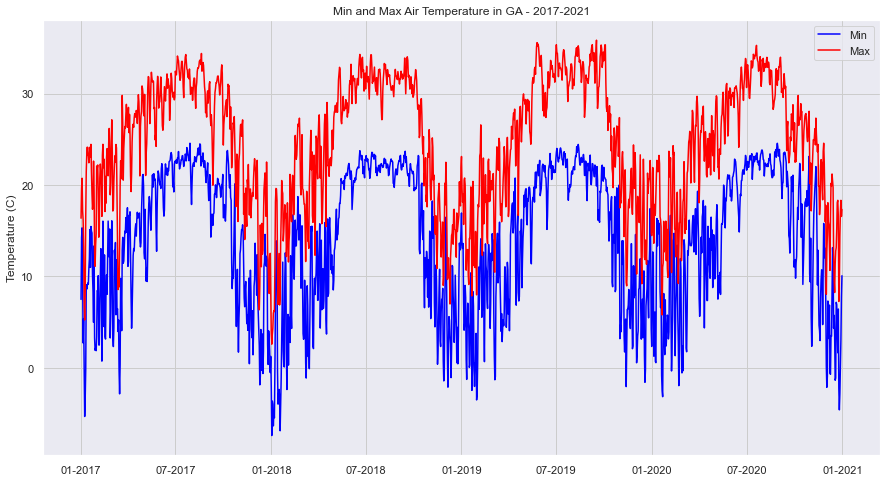

In [285]:
#Subset to Vars of Interest
sub_df = isd_state_data_full_long[(isd_state_data_full_long['Measurement'] == "air_temp_cmin") | (isd_state_data_full_long['Measurement'] == "air_temp_cmax")]

# Boilerplate to set up plots
sns.set()
plt.figure()

# Make the actual plot
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.lineplot(data=sub_df, x="date", y="Value", hue = "Measurement", palette=['blue','red'], sort=False)

myFmt = mdates.DateFormatter('%m-%Y')

# Customize display properties
ax.set_title("Min and Max Air Temperature in GA - 2017-2021")
ax.grid(color='#cccccc')
ax.set_ylabel("Temperature (C)")
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel(None)

plt.legend(title=None, labels=['Min', 'Max'])

plt.show()

In [286]:
isd_state_data_full_long['Measurement'].unique()

array(['air_temp_cmin', 'air_temp_cmax', 'dew_pt_temp_cmin',
       'dew_pt_temp_cmax', 'sea_lvl_press_hectoPamin',
       'sea_lvl_press_hectoPamax', 'wnd_dir_360min', 'wnd_dir_360max',
       'wnd_spd_mtrpersecmin', 'wnd_spd_mtrpersecmax', 'sky_conditionmin',
       'sky_conditionmax', 'precip_hrlymin', 'precip_hrlymax',
       'precip_6hr_accummin', 'precip_6hr_accummax'], dtype=object)

Dew Pt Temp

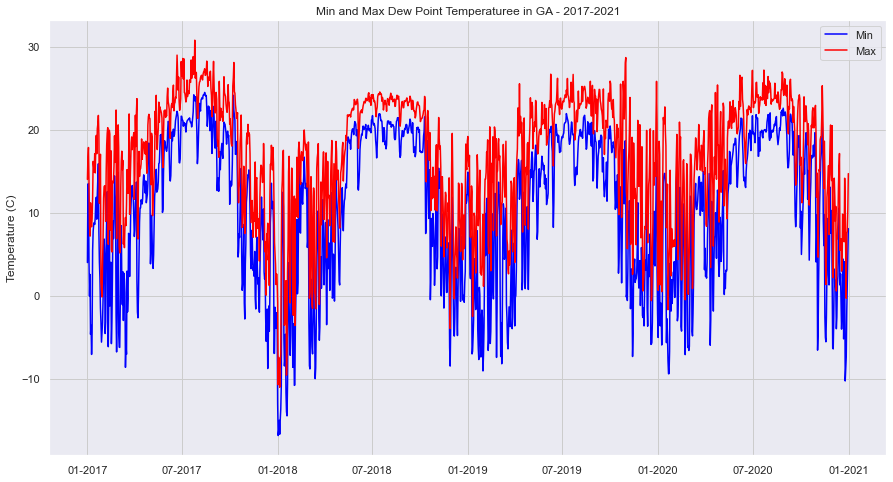

In [287]:
#Subset to Vars of Interest
sub_df = isd_state_data_full_long[(isd_state_data_full_long['Measurement'] == "dew_pt_temp_cmin") | (isd_state_data_full_long['Measurement'] == "dew_pt_temp_cmax")]

# Boilerplate to set up plots
sns.set()
plt.figure()

# Make the actual plot
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.lineplot(data=sub_df, x="date", y="Value", hue = "Measurement", palette=['blue','red'], sort=False)

myFmt = mdates.DateFormatter('%m-%Y')

# Customize display properties
ax.set_title("Min and Max Dew Point Temperaturee in GA - 2017-2021")
ax.grid(color='#cccccc')
ax.set_ylabel("Temperature (C)")
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel(None)

plt.legend(title=None, labels=['Min', 'Max'])

plt.show()

Sea Lvl Press

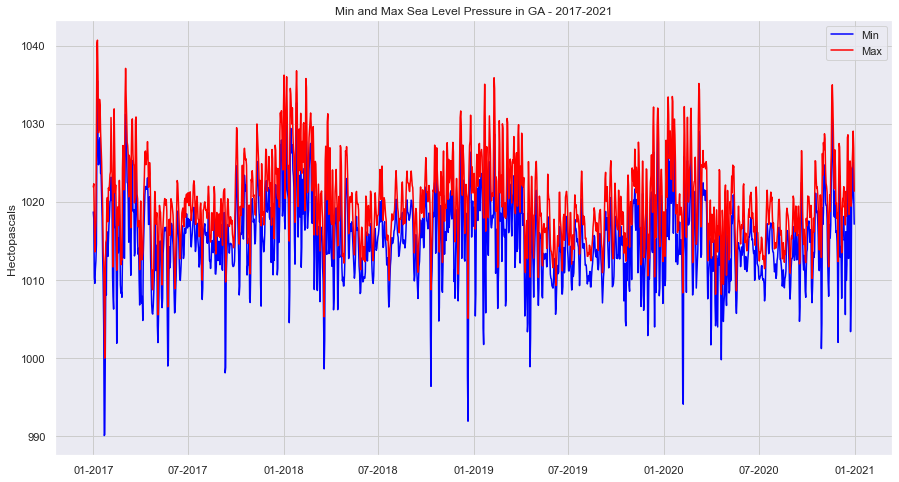

In [288]:
#Subset to Vars of Interest
sub_df = isd_state_data_full_long[(isd_state_data_full_long['Measurement'] == "sea_lvl_press_hectoPamin") | (isd_state_data_full_long['Measurement'] == "sea_lvl_press_hectoPamax")]

# Boilerplate to set up plots
sns.set()
plt.figure()

# Make the actual plot
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.lineplot(data=sub_df, x="date", y="Value", hue = "Measurement", palette=['blue','red'], sort=False)

myFmt = mdates.DateFormatter('%m-%Y')

# Customize display properties
ax.set_title("Min and Max Sea Level Pressure in GA - 2017-2021")
ax.grid(color='#cccccc')
ax.set_ylabel("Hectopascals")
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel(None)

plt.legend(title=None, labels=['Min', 'Max'])

plt.show()

Wind Dir

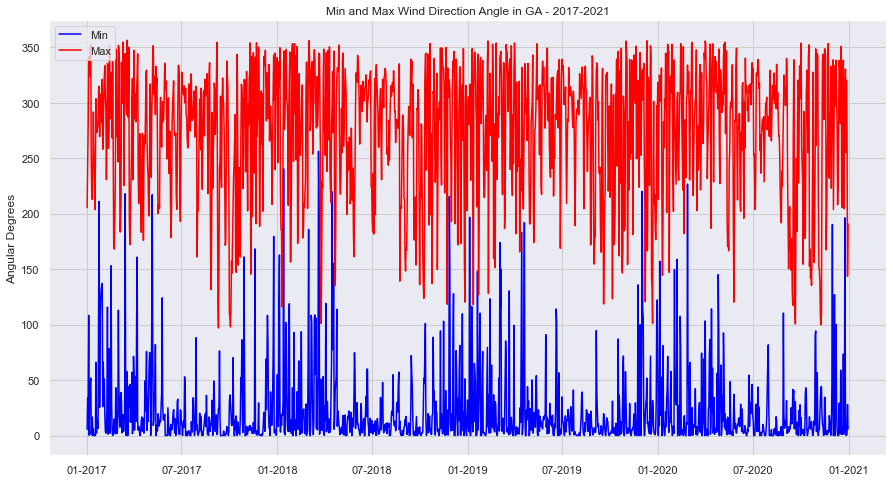

In [289]:
#Subset to Vars of Interest
sub_df = isd_state_data_full_long[(isd_state_data_full_long['Measurement'] == "wnd_dir_360min") | (isd_state_data_full_long['Measurement'] == "wnd_dir_360max")]

# Boilerplate to set up plots
sns.set()
plt.figure()

# Make the actual plot
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.lineplot(data=sub_df, x="date", y="Value", hue = "Measurement", palette=['blue','red'], sort=False)

myFmt = mdates.DateFormatter('%m-%Y')

# Customize display properties
ax.set_title("Min and Max Wind Direction Angle in GA - 2017-2021")
ax.grid(color='#cccccc')
ax.set_ylabel("Angular Degrees")
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel(None)

plt.legend(title=None, labels=['Min', 'Max'])

plt.show()

Wind Speed

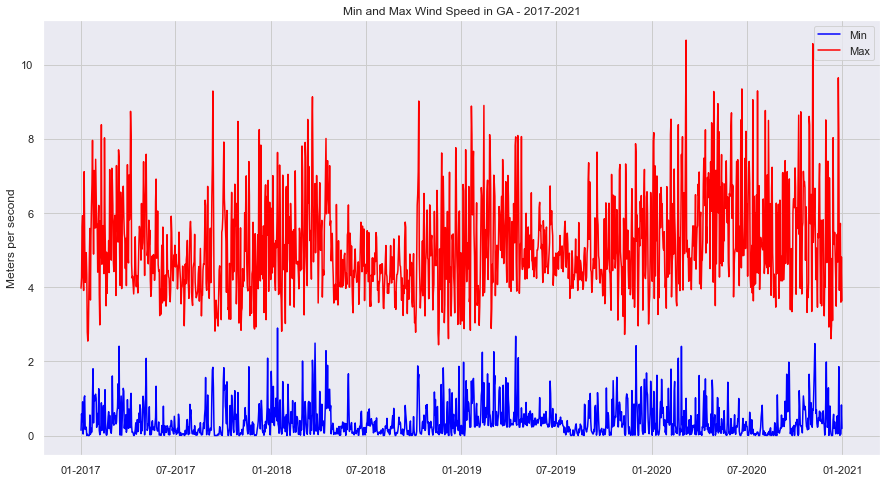

In [290]:
#Subset to Vars of Interest
sub_df = isd_state_data_full_long[(isd_state_data_full_long['Measurement'] == "wnd_spd_mtrpersecmin") | (isd_state_data_full_long['Measurement'] == "wnd_spd_mtrpersecmax")]

# Boilerplate to set up plots
sns.set()
plt.figure()

# Make the actual plot
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.lineplot(data=sub_df, x="date", y="Value", hue = "Measurement", palette=['blue','red'], sort=False)

myFmt = mdates.DateFormatter('%m-%Y')

# Customize display properties
ax.set_title("Min and Max Wind Speed in GA - 2017-2021")
ax.grid(color='#cccccc')
ax.set_ylabel("Meters per second")
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel(None)

plt.legend(title=None, labels=['Min', 'Max'])

plt.show()

Cloud Cover - consider deleting because of scale

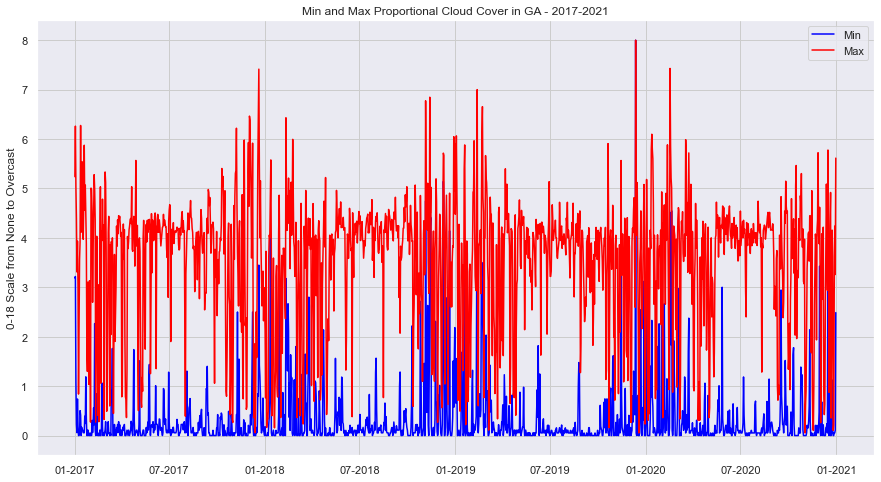

In [291]:
#Subset to Vars of Interest
sub_df = isd_state_data_full_long[(isd_state_data_full_long['Measurement'] == "sky_conditionmin") | (isd_state_data_full_long['Measurement'] == "sky_conditionmax")]

# Boilerplate to set up plots
sns.set()
plt.figure()

# Make the actual plot
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.lineplot(data=sub_df, x="date", y="Value", hue = "Measurement", palette=['blue','red'], sort=False)

myFmt = mdates.DateFormatter('%m-%Y')

# Customize display properties
ax.set_title("Min and Max Proportional Cloud Cover in GA - 2017-2021")
ax.grid(color='#cccccc')
ax.set_ylabel("0-18 Scale from None to Overcast")
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel(None)

plt.legend(title=None, labels=['Min', 'Max'])

plt.show()

 Liquid Precipitation Depth Dimension - One Hour Duration

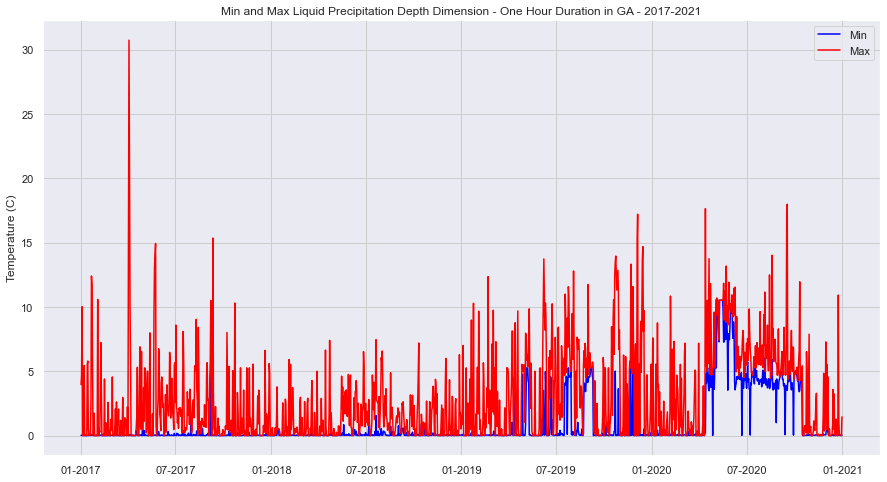

In [292]:
#Subset to Vars of Interest
sub_df = isd_state_data_full_long[(isd_state_data_full_long['Measurement'] == "precip_hrlymin") | (isd_state_data_full_long['Measurement'] == "precip_hrlymax")]

# Boilerplate to set up plots
sns.set()
plt.figure()

# Make the actual plot
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.lineplot(data=sub_df, x="date", y="Value", hue = "Measurement", palette=['blue','red'], sort=False)

myFmt = mdates.DateFormatter('%m-%Y')

# Customize display properties
ax.set_title("Min and Max Liquid Precipitation Depth Dimension - One Hour Duration in GA - 2017-2021")
ax.grid(color='#cccccc')
ax.set_ylabel("Temperature (C)")
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel(None)

plt.legend(title=None, labels=['Min', 'Max'])

plt.show()

 Liquid Precipitation Depth Dimension - Six Hour Duration

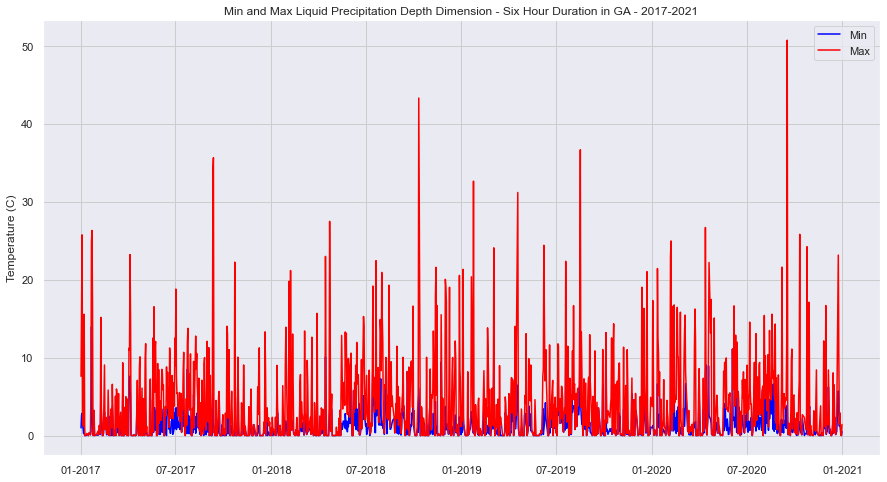

In [293]:
#Subset to Vars of Interest
sub_df = isd_state_data_full_long[(isd_state_data_full_long['Measurement'] == "precip_6hr_accummin") | (isd_state_data_full_long['Measurement'] == "precip_6hr_accummax")]

# Boilerplate to set up plots
sns.set()
plt.figure()

# Make the actual plot
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.lineplot(data=sub_df, x="date", y="Value", hue = "Measurement", palette=['blue','red'], sort=False)

myFmt = mdates.DateFormatter('%m-%Y')

# Customize display properties
ax.set_title("Min and Max Liquid Precipitation Depth Dimension - Six Hour Duration in GA - 2017-2021")
ax.grid(color='#cccccc')
ax.set_ylabel("Temperature (C)")
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel(None)

plt.legend(title=None, labels=['Min', 'Max'])

plt.show()

#### Categorical/Descriptive Information

##### Number of lows below freezing by year

In [304]:
cols = isd_data_full.columns.tolist()
indices = [1,2,3,4,5,25]
in_cols = [cols[i] for i in indices]

In [305]:
isd_df_state = isd_data_full[in_cols].groupby(by=['STATE', 'date', 'year','month','day'], dropna=False, as_index=False).min()

In [306]:
cols = isd_df_state.columns.tolist()
indices = range(0,5)
id_cols = [cols[i] for i in indices]
v_indices = [5]
value_vars = [cols[i] for i in v_indices]

In [307]:
isd_state_data_full_long = isd_df_state.melt(id_vars=id_cols, value_vars=value_vars, var_name="Measurement", value_name="Value", ignore_index=True)

In [308]:
isd_state_data_full_long['below_freezing'] = isd_state_data_full_long['Value'].apply(lambda x: "Below Freezing" if x <0 else "Above Freezing")

In [309]:
sub_df = isd_state_data_full_long[['STATE','year','below_freezing']].groupby(by=['STATE', 'year', 'below_freezing'], dropna=False, as_index=False).size()
sub_df = sub_df[sub_df['below_freezing'] == "Below Freezing"]
sub_df['year'] = sub_df['year'].astype('str')
sub_df['year'] = sub_df['year'].map(lambda x: str(x)[:-2])


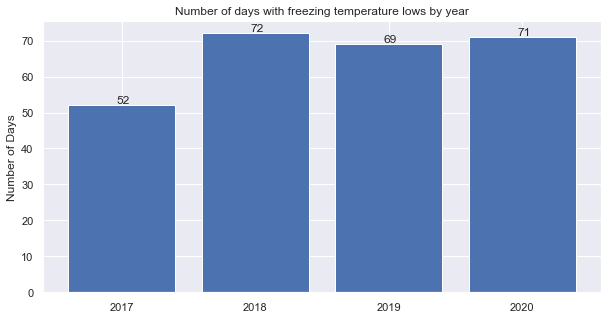

In [310]:
fig1, ax1 = plt.subplots(figsize=(10,5))

barplot = plt.bar(sub_df['year'], sub_df['size'])
for bar in barplot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.2, yval, int(yval), va='bottom') #va: vertical alignment y positional argument
    
plt.title("Number of days with freezing temperature lows by year")
plt.xlabel(None)
plt.ylabel("Number of Days")
plt.savefig(output_bucket + 'freezing_days_ga.png', bbox_inches='tight')
plt.show()

##### Number of days above C equivalent of 100 F

In [311]:
cols = isd_data_full.columns.tolist()
indices = [1,2,3,4,6,25]
in_cols = [cols[i] for i in indices]

isd_df_state = isd_data_full[in_cols].groupby(by=['STATE', 'date', 'year','month','day'], dropna=False, as_index=False).max()

cols = isd_df_state.columns.tolist()
indices = range(0,5)
id_cols = [cols[i] for i in indices]
v_indices = [5]
value_vars = [cols[i] for i in v_indices]

isd_state_data_full_long = isd_df_state.melt(id_vars=id_cols, value_vars=value_vars, var_name="Measurement", value_name="Value", ignore_index=True)

isd_state_data_full_long['above_100f'] = isd_state_data_full_long['Value'].apply(lambda x: "Above 100f" if x>37.7778 else "Below 100f")

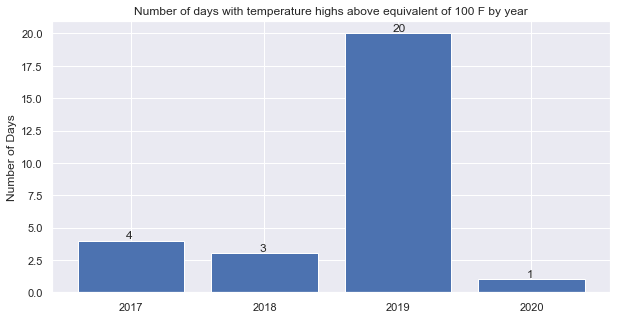

In [312]:
sub_df = isd_state_data_full_long[['STATE','year','above_100f']].groupby(by=['STATE', 'year', 'above_100f'], dropna=False, as_index=False).size()
sub_df = sub_df[sub_df['above_100f'] == "Above 100f"]
sub_df['year'] = sub_df['year'].astype('str')
sub_df['year'] = sub_df['year'].map(lambda x: str(x)[:-2])

fig1, ax1 = plt.subplots(figsize=(10,5))

barplot = plt.bar(sub_df['year'], sub_df['size'])
for bar in barplot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.2, yval, int(yval), va='bottom') #va: vertical alignment y positional argument
    
plt.title("Number of days with temperature highs above equivalent of 100 F by year")
plt.xlabel(None)
plt.ylabel("Number of Days")
plt.savefig(output_bucket + 'hot_days_ga.png', bbox_inches='tight')
plt.show()

#### 6. How many stations have been operating for the entire duration? For less than a year? For two? For three? 

In [321]:
isd_data_full.head()

station_id       date    year  month  day  air_temp_cmin  air_temp_cmax  \
0  720257-63835 2017-01-01  2017.0    1.0  1.0           10.0           21.0   
1  720257-63835 2017-01-01  2017.0    1.0  1.0           10.0           21.0   
2  720257-63835 2017-01-01  2017.0    1.0  1.0           10.0           21.0   
3  720257-63835 2017-01-01  2017.0    1.0  1.0           10.0           21.0   
4  720257-63835 2017-01-02  2017.0    1.0  2.0           18.0           26.0   

   dew_pt_temp_cmin  dew_pt_temp_cmax  sea_lvl_press_hectoPamin  \
0               6.0              19.0                       NaN   
1               6.0              19.0                       NaN   
2               6.0              19.0                       NaN   
3               6.0              19.0                       NaN   
4              17.0              21.0                       NaN   

   sea_lvl_press_hectoPamax  wnd_dir_360min  wnd_dir_360max  \
0                       NaN             0.0           220.0   
1                       NaN             0.0           220.0   
2                       NaN             0.0           220.0   
3                       NaN             0.0           220.0   
4                       NaN             0.0           320.0   

   wnd_spd_mtrpersecmin  wnd_spd_mtrpersecmax  sky_conditionmin  \
0                   0.0                   3.6               NaN   
1                   0.0                   3.6               NaN   
2                   0.0                   3.6               NaN   
3                   0.0                   3.6               NaN   
4                   0.0                   4.6               0.0   

   sky_conditionmax  precip_hrlymin  precip_hrlymax  precip_6hr_accummin  \
0               NaN             NaN             NaN                  NaN   
1               NaN             NaN             NaN                  NaN   
2               NaN             NaN             NaN                  NaN   
3               NaN             NaN             NaN                  NaN   
4               4.0             NaN             NaN                  NaN   

   precip_6hr_accummax    USAF   WBAN          STATION NAME CTRY STATE  ICAO  \
0                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   
1                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   
2                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   
3                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   
4                  NaN  720257  63835  EARLY COUNTY AIRPORT   US    GA  KBIJ   

      LAT     LON  ELEV(M)      BEGIN        END  for_merge  years  \
0  31.397 -84.895     65.2 2006-01-01 2022-03-28          1   2017   
1  31.397 -84.895     65.2 2006-01-01 2022-03-28          1   2018   
2  31.397 -84.895     65.2 2006-01-01 2022-03-28          1   2019   
3  31.397 -84.895     65.2 2006-01-01 2022-03-28          1   2020   
4  31.397 -84.895     65.2 2006-01-01 2022-03-28          1   2017   

            filename  
0  720257-63835-2017  
1  720257-63835-2018  
2  720257-63835-2019  
3  720257-63835-2020  
4  720257-63835-2017

Based on where there is transaction data present in the data

In [320]:
# Fix Dates 
isd_data_full['BEGIN'] = pd.to_datetime(isd_data_full['BEGIN'], format='%Y%m%d')
isd_data_full['END'] = pd.to_datetime(isd_data_full['END'], format='%Y%m%d')

In [325]:
# Create var with contract length 
isd_data_full['from_start_gap'] = (isd_data_full['BEGIN'] - isd_data_full['date'].min()).dt.days
isd_data_full['from_start_gap'] = isd_data_full['from_start_gap'].apply(lambda x: 0 if x<0 else x)

isd_data_full['from_end_gap'] = (isd_data_full['date'].max() - isd_data_full['END']).dt.days
isd_data_full['from_end_gap'] = isd_data_full['from_end_gap'].apply(lambda x: 0 if x<0 else x)

isd_data_full['coverage_gap_days']= isd_data_full['from_start_gap'] + isd_data_full['from_end_gap'] 

isd_data_full['coverage_duryears']= ((365*len(isd_data_full['year'].unique().tolist()))-isd_data_full['coverage_gap_days'])/365

In [326]:
isd_data_full

station_id       date    year  month   day  air_temp_cmin  \
0       720257-63835 2017-01-01  2017.0    1.0   1.0           10.0   
1       720257-63835 2017-01-01  2017.0    1.0   1.0           10.0   
2       720257-63835 2017-01-01  2017.0    1.0   1.0           10.0   
3       720257-63835 2017-01-01  2017.0    1.0   1.0           10.0   
4       720257-63835 2017-01-02  2017.0    1.0   2.0           18.0   
...              ...        ...     ...    ...   ...            ...   
256649  999999-63856 2020-12-30  2020.0   12.0  30.0           12.5   
256650  999999-63856 2020-12-31  2020.0   12.0  31.0           13.4   
256651  999999-63856 2020-12-31  2020.0   12.0  31.0           13.4   
256652  999999-63856 2020-12-31  2020.0   12.0  31.0           13.4   
256653  999999-63856 2020-12-31  2020.0   12.0  31.0           13.4   

        air_temp_cmax  dew_pt_temp_cmin  dew_pt_temp_cmax  \
0                21.0               6.0              19.0   
1                21.0               6.0              19.0   
2                21.0               6.0              19.0   
3                21.0               6.0              19.0   
4                26.0              17.0              21.0   
...               ...               ...               ...   
256649           19.3               NaN               NaN   
256650           21.7               NaN               NaN   
256651           21.7               NaN               NaN   
256652           21.7               NaN               NaN   
256653           21.7               NaN               NaN   

        sea_lvl_press_hectoPamin  sea_lvl_press_hectoPamax  wnd_dir_360min  \
0                            NaN                       NaN             0.0   
1                            NaN                       NaN             0.0   
2                            NaN                       NaN             0.0   
3                            NaN                       NaN             0.0   
4                            NaN                       NaN             0.0   
...                          ...                       ...             ...   
256649                       NaN                       NaN             NaN   
256650                       NaN                       NaN             NaN   
256651                       NaN                       NaN             NaN   
256652                       NaN                       NaN             NaN   
256653                       NaN                       NaN             NaN   

        wnd_dir_360max  wnd_spd_mtrpersecmin  wnd_spd_mtrpersecmax  \
0                220.0                   0.0                   3.6   
1                220.0                   0.0                   3.6   
2                220.0                   0.0                   3.6   
3                220.0                   0.0                   3.6   
4                320.0                   0.0                   4.6   
...                ...                   ...                   ...   
256649             NaN                   0.3                   2.2   
256650             NaN                   0.0                   2.4   
256651             NaN                   0.0                   2.4   
256652             NaN                   0.0                   2.4   
256653             NaN                   0.0                   2.4   

        sky_conditionmin  sky_conditionmax  precip_hrlymin  precip_hrlymax  \
0                    NaN               NaN             NaN             NaN   
1                    NaN               NaN             NaN             NaN   
2                    NaN               NaN             NaN             NaN   
3                    NaN               NaN             NaN             NaN   
4                    0.0               4.0             NaN             NaN   
...                  ...               ...             ...             ...   
256649               NaN               NaN             0.0             0.0   
256650               N

In [327]:
sub_df = isd_data_full.groupby(by = ['station_id'], dropna = False, as_index = False).mean()
sub_df = sub_df.groupby(by = ['coverage_duryears'], dropna = False, as_index = False).size()
sub_df

coverage_duryears  size
0           2.698630     1
1           3.375342     1
2           4.000000    44

All stations but two have been operating over the entire reporting period. 

#### 7.  How many days of each year had threatening winds according to the National Weather Service Scale

Extreme

"An Extreme Threat to Life and Property from High Wind."
"Damaging high wind" with sustained speeds greater than 58 mph, or frequent wind gusts greater than 58 mph. Damaging wind conditions are consistent with a high wind warning.    

High

"A High Threat to Life and Property from High Wind."
"High wind" with sustained speeds of 40 to 57 mph. Wind conditions consistent with a high wind warning. 

Moderate

"A Moderate Threat to Life and Property from High Wind."
"Very windy" with sustained speeds of 26 to 39 mph, or frequent wind gusts of 35 to 57 mph. Wind conditions consistent with a wind advisory. 

Low

"A Low Threat to Life and Property from High Wind."
"Windy" conditions. Sustained wind speeds of 21 to 25 mph, or frequent wind gusts of 30 to 35 mph.

Very Low
" A Very Low Threat to Life and Property from High Wind."
"Breezy" to "Windy" conditions. Sustained wind speeds around 20 mph, or frequent gusts of 25 to 30 mph.

Non-Threatening
" No Discernable Threat to Life and Property from High Wind."
The sustain wind speeds are non-threatening; "breezy" conditions may still be present.Extreme

"An Extreme Threat to Life and Property from High Wind."
"Damaging high wind" with sustained speeds greater than 58 mph, or frequent wind gusts greater than 58 mph. Damaging wind conditions are consistent with a high wind warning.    

High

"A High Threat to Life and Property from High Wind."
"High wind" with sustained speeds of 40 to 57 mph. Wind conditions consistent with a high wind warning. 

Moderate

"A Moderate Threat to Life and Property from High Wind."
"Very windy" with sustained speeds of 26 to 39 mph, or frequent wind gusts of 35 to 57 mph. Wind conditions consistent with a wind advisory. 

Low

"A Low Threat to Life and Property from High Wind."
"Windy" conditions. Sustained wind speeds of 21 to 25 mph, or frequent wind gusts of 30 to 35 mph.

Very Low
" A Very Low Threat to Life and Property from High Wind."
"Breezy" to "Windy" conditions. Sustained wind speeds around 20 mph, or frequent gusts of 25 to 30 mph.

Non-Threatening
" No Discernable Threat to Life and Property from High Wind."
The sustain wind speeds are non-threatening; "breezy" conditions may still be present.

In [347]:
cols = isd_data_full.columns.tolist()
indices = [1,2,3,4,14,25]
in_cols = [cols[i] for i in indices]

In [349]:
isd_df_state = isd_data_full[in_cols].groupby(by=['STATE', 'date', 'year','month','day'], dropna=False, as_index=False).max()

In [350]:
isd_df_state.head()

STATE       date    year  month  day  wnd_spd_mtrpersecmax
0    GA 2017-01-01  2017.0    1.0  1.0                   7.7
1    GA 2017-01-02  2017.0    1.0  2.0                   7.2
2    GA 2017-01-03  2017.0    1.0  3.0                   9.3
3    GA 2017-01-04  2017.0    1.0  4.0                   9.8
4    GA 2017-01-05  2017.0    1.0  5.0                   9.9

In [354]:
#1 meter per second = 2.2369 miles per hour, accurate to 5 significant figures.
# Don't forget to look at scale!
isd_df_state['wnd_spd_mlesperhourmax'] = isd_df_state['wnd_spd_mtrpersecmax'] * 2.2369

In [355]:
def wind_freq(x):
    if x < 25:
        cat = "Non-Threatening"
    elif ((x >= 25) & ( x <30)):
        cat = "Very Low"
    elif ((x >= 30) & ( x <35)):
        cat = "Low"
    elif ((x >= 35) & ( x <47)):
        cat = "Moderate"
    elif ((x >= 47) & ( x <=57)):
        cat = "High"
    elif x >= 58:
        cat = "Exteme"
    else:
        cat= np.nan
    return cat
        
def wind_sus(x):
    if x < 20:
        cat = "Non-Threatening"
    elif ((x >= 20) & ( x <21)):
        cat = "Very Low"
    elif ((x >= 21) & ( x <=25)):
        cat = "Low"
    elif ((x >= 26) & ( x <=39)):
        cat = "Moderate"
    elif ((x >= 40) & ( x <=57)):
        cat = "High"
    elif x >= 58:
        cat = "Extreme"
    else:
        cat=np.nan
    return cat

In [356]:
isd_df_state['wind_freq_cat'] = isd_df_state['wnd_spd_mlesperhourmax'].apply(lambda x: wind_freq(x))
isd_df_state['wind_freq_sus'] = isd_df_state['wnd_spd_mlesperhourmax'].apply(lambda x: wind_sus(x))

In [357]:
isd_df_state.head()

STATE       date    year  month  day  wnd_spd_mtrpersecmax  \
0    GA 2017-01-01  2017.0    1.0  1.0                   7.7   
1    GA 2017-01-02  2017.0    1.0  2.0                   7.2   
2    GA 2017-01-03  2017.0    1.0  3.0                   9.3   
3    GA 2017-01-04  2017.0    1.0  4.0                   9.8   
4    GA 2017-01-05  2017.0    1.0  5.0                   9.9   

   wnd_spd_mlesperhourmax    wind_freq_cat    wind_freq_sus  
0                17.22413  Non-Threatening  Non-Threatening  
1                16.10568  Non-Threatening  Non-Threatening  
2                20.80317  Non-Threatening         Very Low  
3                21.92162  Non-Threatening              Low  
4                22.14531  Non-Threatening              Low

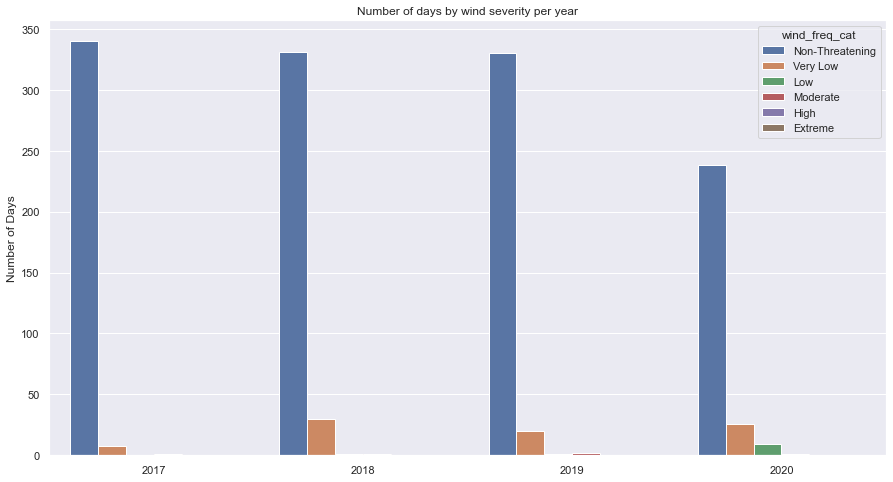

In [364]:
# Count of stations recording those categories by year
sub_df = isd_df_state[['STATE','year','wind_freq_cat']].groupby(by=['STATE', 'year', 'wind_freq_cat'], dropna=False, as_index=False).size()
sub_df['year'] = sub_df['year'].astype('str')
sub_df['year'] = sub_df['year'].map(lambda x: str(x)[:-2])
sub_df.head()

sns.barplot(x='year',y='size',hue='wind_freq_cat', hue_order = ['Non-Threatening', "Very Low", "Low", "Moderate", "High", "Extreme"], data=sub_df)
    
plt.title("Number of days by wind severity per year")
plt.xlabel(None)
plt.ylabel("Number of Days")
plt.savefig(output_bucket + 'high_wind_ga.png', bbox_inches='tight')
plt.show()
plt.show()

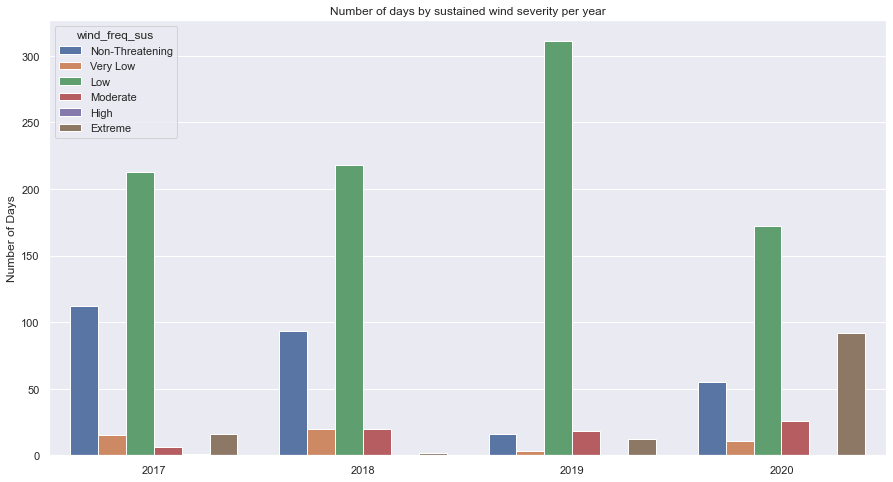

In [365]:
# Count of stations recording those categories by year
sub_df = isd_df_state[['STATE','year','wind_freq_sus']].groupby(by=['STATE', 'year', 'wind_freq_sus'], dropna=False, as_index=False).size()
sub_df['year'] = sub_df['year'].astype('str')
sub_df['year'] = sub_df['year'].map(lambda x: str(x)[:-2])
sub_df.head()

sns.barplot(x='year',y='size',hue='wind_freq_sus', hue_order = ['Non-Threatening', "Very Low", "Low", "Moderate", "High", "Extreme"],data=sub_df)
    
plt.title("Number of days by sustained wind severity per year")
plt.xlabel(None)
plt.ylabel("Number of Days")
plt.savefig(output_bucket + 'high_wind_sus_ga.png', bbox_inches='tight')
plt.show()
plt.show()